In [ ]:
# ── universal run-folder resolver ─────────────────────────────────────
from pathlib import Path
import os, yaml

CFG_FILE = Path(os.getenv("PIPELINE_CFG", "pipeline_config.yaml")).expanduser()
CFG = yaml.safe_load(CFG_FILE.read_text()) or {}
DEFAULTS = CFG.get("defaults", {})
EVENTS   = {str(k): v for k, v in CFG.get("events", {}).items()}

SWAN_YEAR = str(os.getenv("SWAN_YEAR", next(iter(EVENTS))))
OUTPUT_ROOT = Path(DEFAULTS["OUTPUT_ROOT"]).expanduser()
EVENT_DIR   = OUTPUT_ROOT / f"event={SWAN_YEAR}"

RUN_DIR = (Path(os.getenv("RUN_DIR")).expanduser()
           if os.getenv("RUN_DIR") else
           (EVENT_DIR / os.getenv("RUN_DATE") if os.getenv("RUN_DATE")
            else max(EVENT_DIR.iterdir(), key=lambda p: p.stat().st_mtime)))

print(f"[bootstrap] RUN_DIR = {RUN_DIR}")
# make the variable visible to the rest of the notebook
globals()["RUN_DIR"] = RUN_DIR
# ──────────────────────────────────────────────────────────────────────

1. Summary statistics (overall, portfolio, market):


,Metric,Group,mean,median,std,min,max,count
0,Physical_Score,Overall,2.230,2.333,0.721,1.000,5.000,34449.000
1,Information_Score,Overall,2.059,2.000,0.609,1.000,4.000,33384.000
2,Cognitive_Score,Overall,2.204,2.333,1.055,1.000,4.500,34862.000
3,Social_Score,Overall,2.744,2.750,0.780,1.000,5.000,34517.000
4,Prepare_Score,Overall,2.063,2.333,0.617,1.000,4.000,34484.000
5,Absorb_Score,Overall,1.620,1.750,0.571,1.000,4.000,34660.000
6,Recover_Score,Overall,2.573,2.500,0.597,1.000,5.000,34484.000
7,Adapt_Score,Overall,2.918,2.750,0.756,1.000,5.000,34862.000
8,RISE_Score,Overall,2.286,2.292,0.490,1.000,3.625,34862.000
9,Physical_Score,Market,2.224,2.333,0.721,1.000,5.000,34115.000



2. High/Low RISE_Score group means (by portfolio):


,hi_lo,is_portfolio,Physical_Score,Information_Score,Cognitive_Score,Social_Score,Prepare_Score,Absorb_Score,Recover_Score,Adapt_Score,RISE_Score
0,High,False,2.618,2.264,3.049,2.958,2.470,2.065,2.790,3.473,2.700
1,High,True,2.901,2.405,3.320,2.648,2.592,2.025,2.826,3.705,2.787
2,Low,False,1.822,1.831,1.343,2.529,1.637,1.166,2.346,2.352,1.865
3,Low,True,2.557,1.500,1.503,2.365,2.181,1.005,2.544,2.444,2.003



3. Group t-tests and effect sizes (first 10 rows):


,Year,Metric,t_stat,p_val,cohen_d,port_mean,mkt_mean
0,1989.000,Physical_Score,1.154,0.364,0.489,2.722,2.551
1,1989.000,Information_Score,0.670,0.621,0.419,1.333,1.108
2,1989.000,Cognitive_Score,1.848,0.206,2.876,2.556,1.117
3,1989.000,Social_Score,1.840,0.204,1.108,2.611,1.892
4,1989.000,Prepare_Score,2.864,0.089,0.705,2.278,1.842
5,1989.000,Absorb_Score,1.343,0.311,1.841,1.889,1.099
6,1989.000,Recover_Score,1.790,0.213,1.170,2.611,1.912
7,1989.000,Adapt_Score,2.945,0.097,1.789,3.500,2.022
8,1989.000,RISE_Score,3.176,0.085,1.928,2.569,1.569
9,1990.000,Physical_Score,-3.911,0.036,-0.532,2.639,2.949



4. Histogram of RISE_Score (market vs portfolio):


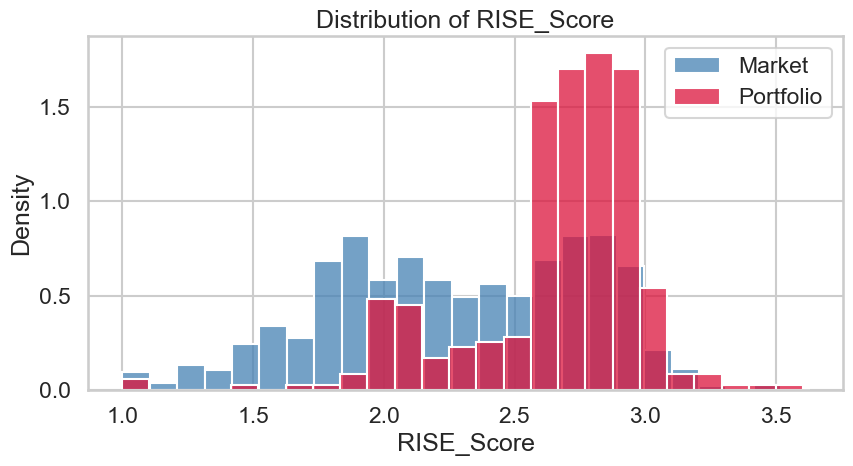


5. Mean RISE_Score per year (portfolio vs market):


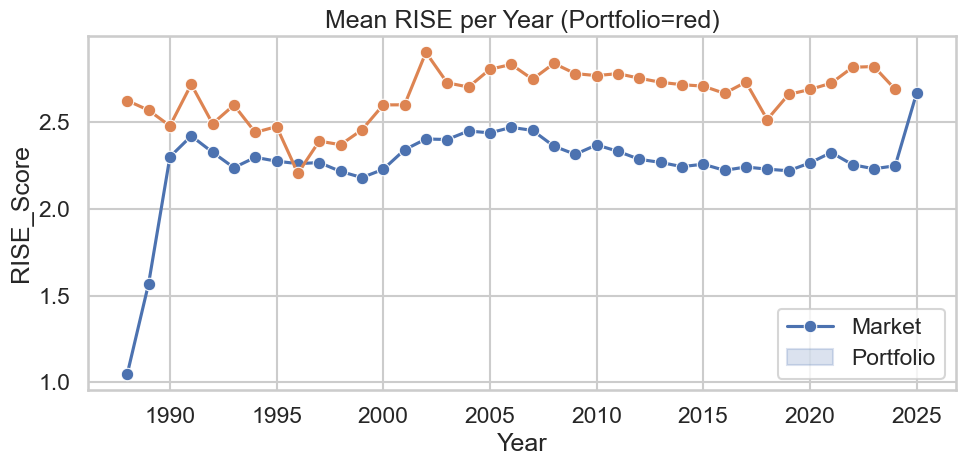


6. Boxplot of RISE_Score per year (portfolio vs market):


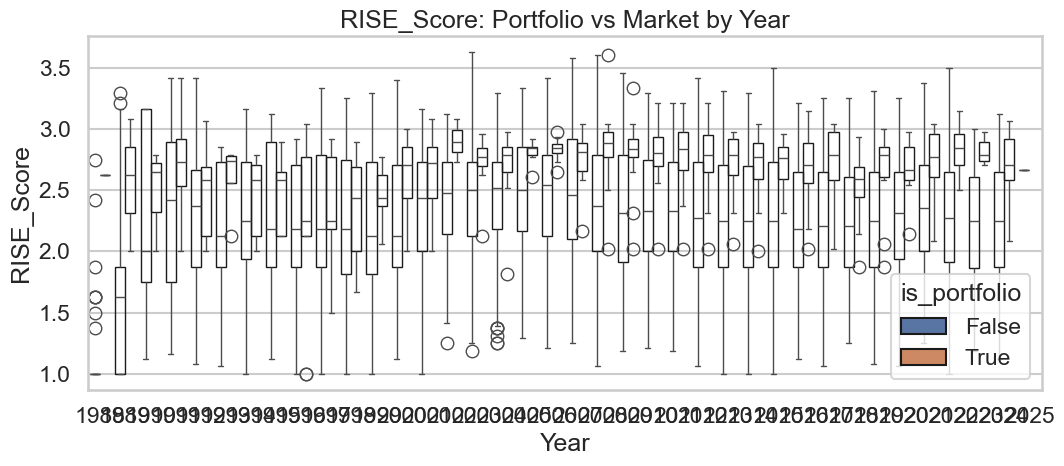


7. Heatmap: Mean RISE_Score by year and group:


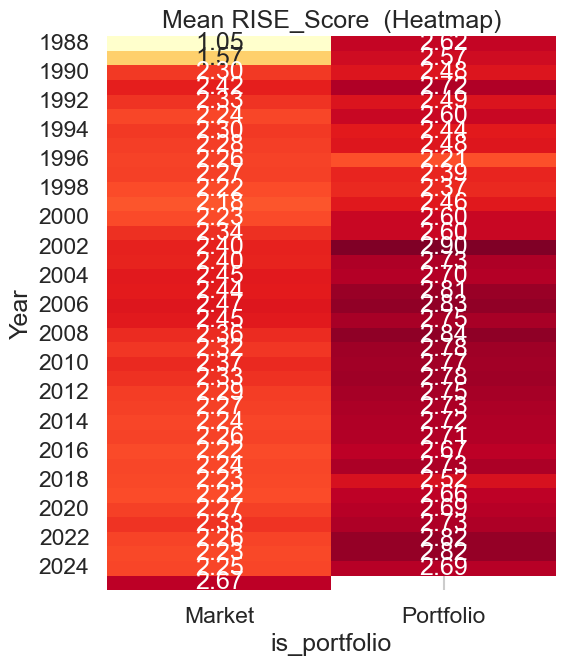


8. Per-stock RISE_Score trajectories (first 6 stocks):


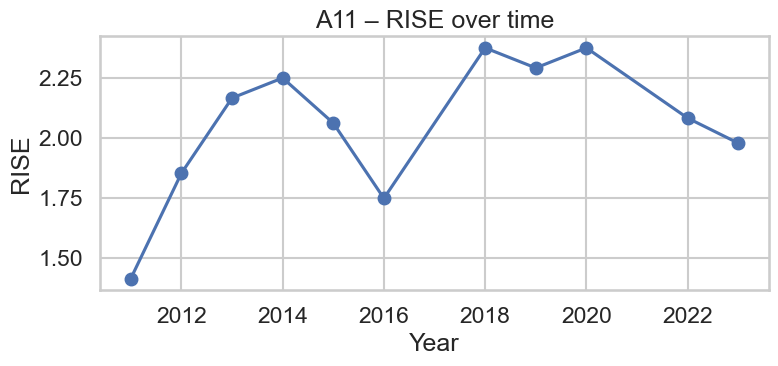

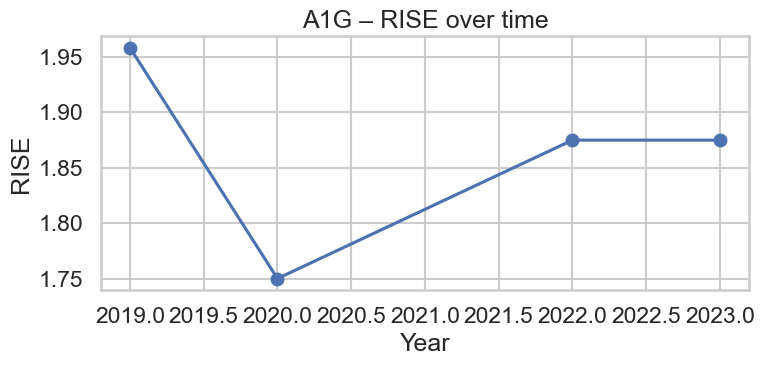

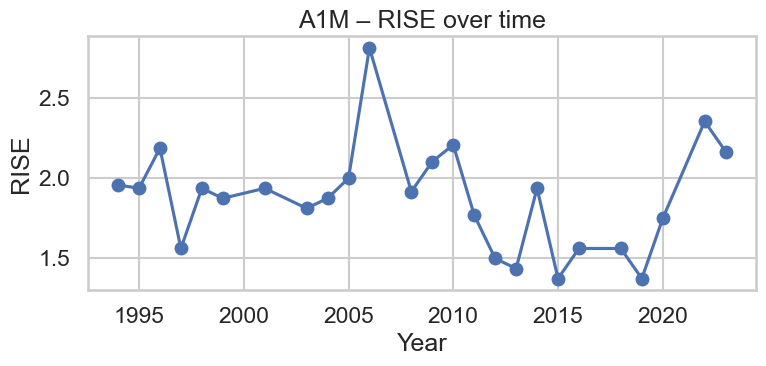

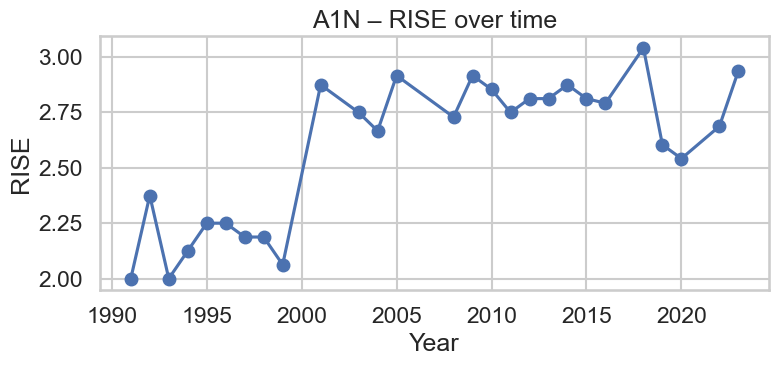

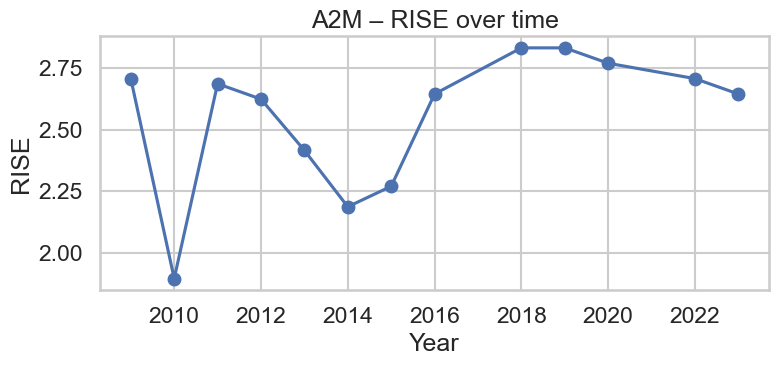

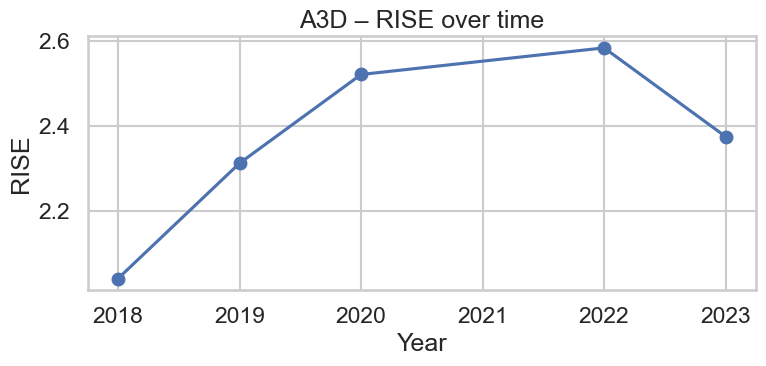

Portfolio RISE_Score for 2007–2009 and mean:


Year,Symbol,Name,2007,2008,2009,Mean_2007_2009
0,ALL,ALL,nan,2.917,2.792,2.854
1,AMP,AMP,nan,2.500,2.312,2.406
2,ANZ,ANZ,nan,2.979,2.854,2.917
3,BHP,BHP,2.896,2.979,2.917,2.931
4,BXB,BXB,nan,2.917,2.917,2.917
5,CBA,CBA,2.979,3.042,3.042,3.021
6,COH,COH,2.854,2.854,2.792,2.833
7,IRE,IRE,2.688,2.771,2.771,2.743
8,JBH,JBH,2.646,nan,nan,2.646
9,MQG,MQG,nan,3.604,3.333,3.469


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Jason Pohl\\OneDrive - Bond University\\PhD\\rff\\outputs_rff\\event=2008\\20250609\\stage22\\Portfolio_RISEScore_2007_2009.csv'

In [5]:
#!/usr/bin/env python
"""
Stage 22 · Ultimate Portfolio-vs-Market Resilience Dashboard
Combines summary tables, group stats, t-tests, effect sizes, and rich notebook visuals.
"""

from __future__ import annotations
import os, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from IPython.display import display

# ╔══════════════════════════════════════╗
# 0 · CONFIGURATION
# ╚══════════════════════════════════════╝
SWAN_YEAR = os.getenv("SWAN_YEAR", "2008")
RUN_DATE  = os.getenv("RUN_DATE" , "20250609")
OUTPUT_ROOT = Path(
    r"C:\Users\Jason Pohl\OneDrive - Bond University\PhD\rff\outputs_rff"
).expanduser()

# ── UPDATED PORTFOLIO LIST ──
PORTFOLIO_TICKERS: list[str] = [
    "RIO","ANZ","BXB","BHP","WPL",
    "BAB","CBA","AMP","PTM","ALL",
    "COH","WOW","MQG","JBH","SEK",
    "MOC","GTP","BBG","CAB","QGC",
    "AAQ","CDS","VGH","IRE","WOR"
]

# ╔══════════════════════════════════════╗
# 1 · LOAD CORE SCORE TABLE (Stage 05A)
# ╚══════════════════════════════════════╝
stage05a_dir = OUTPUT_ROOT / f"event={SWAN_YEAR}" / RUN_DATE / "stage05a"
scores_csv   = stage05a_dir / "Stage5A_QuintilesAndScores.csv"
if not scores_csv.is_file():
    raise FileNotFoundError(f"Stage 05A CSV not found: {scores_csv}")
df = pd.read_csv(scores_csv, low_memory=False)
if "Year" in df:
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

df["is_portfolio"] = df["Symbol"].isin(PORTFOLIO_TICKERS)

# Optionally add Stage03/11 data here if you want
# (not required for core notebook outputs)

SCORE_COLS  = [c for c in df.columns if c.endswith("_Score")]
DOMAIN_COLS = [c for c in SCORE_COLS if c != "RISE_Score"]
STAGE22_DIR = OUTPUT_ROOT / f"event={SWAN_YEAR}" / RUN_DATE / "stage22"
STAGE22_DIR.mkdir(parents=True, exist_ok=True)

# ╔══════════════════════════════════════╗
# 2 · SUMMARY FUNCTIONS
# ╚══════════════════════════════════════╝
def summarize(group: pd.DataFrame, label:str)->pd.DataFrame:
    stats_df = group[SCORE_COLS].agg(["mean","median","std","min","max","count"]).T
    stats_df.insert(0,"Group",label)
    stats_df.reset_index(inplace=True)
    stats_df.rename(columns={"index":"Metric"}, inplace=True)
    return stats_df

overall_stats   = summarize(df, "Overall")
portfolio_stats = summarize(df[df.is_portfolio], "Portfolio")
market_stats    = summarize(df[~df.is_portfolio], "Market")
summary_all = pd.concat([overall_stats, market_stats, portfolio_stats], ignore_index=True)
summary_all.to_csv(STAGE22_DIR / "Summary_Overall_Portfolio_Market.csv", index=False)

# ╔══════════════════════════════════════╗
# 3 · VISUALISATIONS: Save to File
# ╚══════════════════════════════════════╝
sns.set(style="whitegrid", context="talk")
warnings.filterwarnings("ignore", category=FutureWarning)

# histogram of RISE
plt.figure(figsize=(9,5))
sns.histplot(df["RISE_Score"], bins=25, label="Market",stat="density",color="steelblue")
sns.histplot(df[df.is_portfolio]["RISE_Score"], bins=25,label="Portfolio",
             stat="density",color="crimson")
plt.title("Distribution of RISE_Score")
plt.legend(); plt.tight_layout()
plt.savefig(STAGE22_DIR/"Hist_RISE_Portfolio_vs_Market.png"); plt.close()

# mean-per-year line plot
line = (df.groupby(["Year","is_portfolio"])["RISE_Score"]
          .mean().reset_index())
plt.figure(figsize=(10,5))
sns.lineplot(data=line,x="Year",y="RISE_Score",
             hue="is_portfolio",marker="o")
plt.title("Mean RISE per Year (Portfolio=red)")
plt.legend(labels=["Market","Portfolio"])
plt.tight_layout();plt.savefig(STAGE22_DIR/"Line_RISE_ByYear.png");plt.close()

# boxplots per year & group
boxprops=dict(facecolor="None", edgecolor="k")
for col in DOMAIN_COLS+["RISE_Score"]:
    plt.figure(figsize=(11,5))
    sns.boxplot(data=df,x="Year",y=col,hue="is_portfolio",boxprops=boxprops)
    plt.title(f"{col}: Portfolio vs Market by Year")
    plt.tight_layout()
    plt.savefig(STAGE22_DIR/f"Box_{col}_ByYear.png")
    plt.close()

# heat-map of yearly means (portfolio & market)
pivot = (df.pivot_table(index="Year", columns="is_portfolio",
                        values="RISE_Score", aggfunc="mean")
          .rename(columns={False:"Market",True:"Portfolio"}))
plt.figure(figsize=(6,7))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd", cbar=False)
plt.title("Mean RISE_Score  (Heatmap)")
plt.tight_layout()
plt.savefig(STAGE22_DIR/"Heatmap_RISE_Mean.png"); plt.close()

# ╔══════════════════════════════════════╗
# 4 · t-TESTS  &  COHEN d
# ╚══════════════════════════════════════╝
def cohens_d(a,b):
    nx, ny = len(a), len(b)
    pooled = np.sqrt(((nx-1)*a.var(ddof=1) + (ny-1)*b.var(ddof=1)) / (nx+ny-2)) if (nx+ny-2)>0 else np.nan
    return (a.mean()-b.mean())/pooled if pooled>0 else np.nan

results=[]
for yr in sorted(df["Year"].dropna().unique()):
    sub=df[df.Year==yr]
    for col in SCORE_COLS:
        p=sub[sub.is_portfolio][col].dropna()
        m=sub[~sub.is_portfolio][col].dropna()
        if len(p)>1 and len(m)>1:
            t,pv = stats.ttest_ind(p,m,equal_var=False)
            results.append({"Year":yr,"Metric":col,
                            "t_stat":t,"p_val":pv,"cohen_d":cohens_d(p,m),
                            "port_mean":p.mean(),"mkt_mean":m.mean()})
tres=pd.DataFrame(results)
tres.to_csv(STAGE22_DIR/"Group_tTests_EffectSizes.csv",index=False)

# ╔══════════════════════════════════════╗
# 5 · HIGH / LOW  SPLIT  (by median RISE)
# ╚══════════════════════════════════════╝
median_rise = df["RISE_Score"].median()
df["hi_lo"] = np.where(df["RISE_Score"]>=median_rise,"High","Low")
hi_lo_stats = (df.groupby(["hi_lo","is_portfolio"])[SCORE_COLS]
                 .mean().reset_index())
hi_lo_stats.to_csv(STAGE22_DIR/"HighLow_MeanScores.csv",index=False)

# ╔══════════════════════════════════════╗
# 6 · PER-STOCK TRAJECTORIES (example)
# ╚══════════════════════════════════════╝
SAMPLE = df["Symbol"].drop_duplicates().head(6)
for sym in SAMPLE:
    tmp=df[df.Symbol==sym]
    plt.figure(figsize=(8,4))
    plt.plot(tmp["Year"], tmp["RISE_Score"],marker="o")
    plt.title(f"{sym}  –  RISE over time"); plt.xlabel("Year"); plt.ylabel("RISE")
    plt.tight_layout()
    plt.savefig(STAGE22_DIR/f"Trajectory_{sym}.png")
    plt.close()

# ╔══════════════════════════════════════╗
# 7 · OLS TREND REGRESSION  (Year × Group)
# ╚══════════════════════════════════════╝
reg_df=df.dropna(subset=["Year","RISE_Score"])
reg_df["Group"]=reg_df["is_portfolio"].map({True:"Portfolio",False:"Market"})
mod = smf.ols("RISE_Score ~ Year * Group", data=reg_df).fit()
with open(STAGE22_DIR/"OLS_Year_Group.txt","w") as fh:
    fh.write(mod.summary().as_text())

# ╔══════════════════════════════════════╗
# 8 · NOTEBOOK SUMMARY OUTPUTS
# ╚══════════════════════════════════════╝

def safe_format(df, caption=None):
    import numpy as np
    fmt_dict = {col: "{:.3f}" for col in df.select_dtypes(include=[np.number]).columns}
    sty = df.style.format(fmt_dict)
    if caption:
        try:
            sty = sty.set_caption(caption)
        except Exception:
            pass
    display(sty)

print("1. Summary statistics (overall, portfolio, market):")
safe_format(summary_all, "Summary Statistics")

print("\n2. High/Low RISE_Score group means (by portfolio):")
safe_format(hi_lo_stats, "High/Low RISE Means")

print("\n3. Group t-tests and effect sizes (first 10 rows):")
safe_format(tres.head(10), "t-tests & Cohen's d")

print("\n4. Histogram of RISE_Score (market vs portfolio):")
plt.figure(figsize=(9,5))
sns.histplot(df["RISE_Score"], bins=25, label="Market",stat="density",color="steelblue")
sns.histplot(df[df.is_portfolio]["RISE_Score"], bins=25,label="Portfolio",
             stat="density",color="crimson")
plt.title("Distribution of RISE_Score")
plt.legend(); plt.tight_layout()
plt.show()

print("\n5. Mean RISE_Score per year (portfolio vs market):")
plt.figure(figsize=(10,5))
sns.lineplot(data=line,x="Year",y="RISE_Score",
             hue="is_portfolio",marker="o")
plt.title("Mean RISE per Year (Portfolio=red)")
plt.legend(labels=["Market","Portfolio"])
plt.tight_layout()
plt.show()

print("\n6. Boxplot of RISE_Score per year (portfolio vs market):")
plt.figure(figsize=(11,5))
sns.boxplot(data=df,x="Year",y="RISE_Score",hue="is_portfolio",boxprops=dict(facecolor="None", edgecolor="k"))
plt.title("RISE_Score: Portfolio vs Market by Year")
plt.tight_layout()
plt.show()

print("\n7. Heatmap: Mean RISE_Score by year and group:")
plt.figure(figsize=(6,7))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd", cbar=False)
plt.title("Mean RISE_Score  (Heatmap)")
plt.tight_layout()
plt.show()

print("\n8. Per-stock RISE_Score trajectories (first 6 stocks):")
for sym in SAMPLE:
    tmp=df[df.Symbol==sym]
    plt.figure(figsize=(8,4))
    plt.plot(tmp["Year"], tmp["RISE_Score"],marker="o",label=sym)
    plt.title(f"{sym} – RISE over time"); plt.xlabel("Year"); plt.ylabel("RISE")
    plt.tight_layout()
    plt.show()


    # ╔══════════════════════════════════════════════════════════════════╗
# 10 · PORTFOLIO TABLE: RISE_Score for 2007, 2008, 2009 + mean col
# ╚══════════════════════════════════════════════════════════════════╝

# 1. Years of interest
years_of_interest = [2007, 2008, 2009]

# 2. Filter portfolio stocks only
portfolio_df = df[df["is_portfolio"]].copy()

# 3. Try to get company names if available (fallback: use Symbol)
name_col = None
for possible in ["Name", "Company", "Short_Name", "Company_Name"]:
    if possible in portfolio_df.columns:
        name_col = possible
        break
if name_col is None:
    portfolio_df["DisplayName"] = portfolio_df["Symbol"]
else:
    portfolio_df["DisplayName"] = portfolio_df[name_col]

# 4. Pivot: Symbol, Name, 2007, 2008, 2009
matrix = portfolio_df[portfolio_df["Year"].isin(years_of_interest)].pivot_table(
    index=["Symbol","DisplayName"],
    columns="Year",
    values="RISE_Score",
    aggfunc="mean"
).reset_index()

# 5. Calculate average across 2007-2009
matrix["Mean_2007_2009"] = matrix[[yr for yr in years_of_interest if yr in matrix.columns]].mean(axis=1)

# 6. Rename columns for clarity
col_map = {yr: str(yr) for yr in years_of_interest}
matrix = matrix.rename(columns=col_map)
matrix = matrix[["Symbol","DisplayName"] + [str(yr) for yr in years_of_interest] + ["Mean_2007_2009"]]
matrix = matrix.rename(columns={"DisplayName": "Name"})

# 7. Display and save
def safe_format_table(df, caption=None):
    import numpy as np
    fmt_dict = {col: "{:.3f}" for col in df.select_dtypes(include=[np.number]).columns}
    sty = df.style.format(fmt_dict).set_properties(**{'text-align': 'left'})
    if caption:
        try:
            sty = sty.set_caption(caption)
        except Exception:
            pass
    display(sty)

print("Portfolio RISE_Score for 2007–2009 and mean:")
safe_format_table(matrix, "Portfolio RISE_Score (2007, 2008, 2009) + Mean")

matrix.to_csv(STAGE22_DIR / "Portfolio_RISEScore_2007_2009.csv", index=False)

print("\n✅ Stage 22 complete — outputs in:", STAGE22_DIR)